In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from langdetect import detect_langs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('ratebeer.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,name,id,brewerID,abv,style,appearance,aroma,palate,taste,overall,time,profileName,reviewtext
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Mar,10-Jun,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Apr,10-Jul,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,5-Apr,10-May,5-Mar,10-Jun,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


In [4]:
df_1 = df.sample(frac=0.25)
df_1.shape

(262144, 13)

In [5]:
df_2 = df.sample(frac=0.05)
df_2.shape

(52429, 13)

In [6]:
df_3 = df_2[['name', 'reviewtext']]
df_3.head()

,name,reviewtext
715151,Roots Organic Hotsteppa Golden Ale,Golden colour. Fruity hop aroma with light pa...
470842,AleSmith X,22 oz. bottle from Johns Market Place. A huge ...
906055,Stoudts Blonde Double Mai-bock,Yeast and caramel rolled into a beer that I ho...
155830,New Holland The Poet,"Bottle. pours dark. dry and bitter, not very..."
302268,Hair of the Dog Ruth,Pour is hazy golden yellow with a quick head. ...


In [7]:
df_3 = df_3.rename(columns={'reviewtext': 'review'})

# length of the reviews
length_reviews = df_3.review.str.len()
df_3['length'] = length_reviews
df_3.head()

,name,review,length
715151,Roots Organic Hotsteppa Golden Ale,Golden colour. Fruity hop aroma with light pa...,309.0
470842,AleSmith X,22 oz. bottle from Johns Market Place. A huge ...,817.0
906055,Stoudts Blonde Double Mai-bock,Yeast and caramel rolled into a beer that I ho...,149.0
155830,New Holland The Poet,"Bottle. pours dark. dry and bitter, not very...",178.0
302268,Hair of the Dog Ruth,Pour is hazy golden yellow with a quick head. ...,216.0


In [8]:
avg_length = df_3.length.mean()
print('Average Length: {}'.format(avg_length))

Average Length: 309.94192796852917


In [9]:
longest_review = df_3['length'].max()
shortest_review = df_3['length'].min()
print('Longest Review: {}'.format(longest_review))
print('Shortest Review: {}'.format(shortest_review))

Longest Review: 4444.0
Shortest Review: 5.0


In [10]:
df_4 = df_3.sort_values(by=['length'], ascending=False)
df_4.head()

,name,review,length
324481,Snoqualmie Falls Spring Fever Belgian Grand Cru,"UPDATED: FEB 25, 2011 Snoqualmie Falls Brewing...",4444.0
264929,Stone Old Guardian &#40;Vintages 2004 and late...,"UPDATED: JAN 27, 2007 Jan 2007, bottled.\t\tLo...",3696.0
856994,Arbor Demetrius Barrel Aged Sour Double IPA,This one has sat in the back of the fridge for...,3577.0
120565,Firestone Walker 10,Sampled March 2007\tThis produces a very thick...,3315.0
265390,Stone Old Guardian &#40;Vintages 2004 and late...,While my personal preference leans more toward...,3273.0


In [11]:
reviews = df_4.sample(frac=0.50)
reviews.head()

,name,review,length
808826,George Killians Irish Red,"I like this beer, it tastes good and has a goo...",119.0
804739,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...,274.0
684228,De Dolle Stille Nacht,"Bottle, bought @ Kolding Vinhandel. [Vintage 2...",548.0
660030,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...,393.0
537582,Chapeau Faro,Sampled alongside Lindeman's Faro. The front l...,1611.0


In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26214 entries, 808826 to 684789
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    26214 non-null  object 
 1   review  26182 non-null  object 
 2   length  26182 non-null  float64
dtypes: float64(1), object(2)
memory usage: 819.2+ KB


In [13]:
review = str(reviews.review)

In [14]:
languages = []

for r in range(len(reviews)):
    languages.append(detect_langs(reviews.iloc[r, 0]))

In [15]:
languages = [str(lang).split(':')[0][1] for lang in languages]

In [16]:
reviews['lang'] = languages
reviews.head()

,name,review,length,lang
808826,George Killians Irish Red,"I like this beer, it tastes good and has a goo...",119.0,e
804739,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...,274.0,e
684228,De Dolle Stille Nacht,"Bottle, bought @ Kolding Vinhandel. [Vintage 2...",548.0,d
660030,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...,393.0,e
537582,Chapeau Faro,Sampled alongside Lindeman's Faro. The front l...,1611.0,p


In [114]:
reviews['lang'].value_counts()

e    13780
d     5583
n     1570
f     1151
i     1149
s      764
a      582
c      563
t      401
p      259
r      190
h      156
l       61
v        5
Name: lang, dtype: int64

In [17]:
# Removing non english reviews and Keeping only reviews in english

reviews_e = reviews.loc[lambda reviews: reviews['lang'] == 'e']
reviews_e

,name,review,length,lang
808826,George Killians Irish Red,"I like this beer, it tastes good and has a goo...",119.0,e
804739,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...,274.0,e
660030,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...,393.0,e
495579,Stillwater/Olivers Channel Crossing,Draft @ Capones. Brown pour with tan head. Swe...,144.0,e
285990,Alpine Beer Company Willy,"Meh, not to impressed with this. Wheaty nose a...",126.0,e
...,...,...,...,...
579386,Melbourn Brothers Strawberry,Noticably more red - basically an amber - than...,270.0,e
72757,Lagunitas New DogTown Pale Ale,Several on Draught at the Black Crowes shows a...,473.0,e
1010603,North Coast Red Seal Ale,Poured a copper color with minimal head. Hoppy...,126.0,e
658246,Cigar City Maduro Oatmeal Brown Ale - Vanilla ...,Pours a standard medioum brown with a small am...,377.0,e


In [18]:
avg_length_e = reviews_e.length.mean()
longest_review_e = reviews_e['length'].max()
shortest_review_e = reviews_e['length'].min()
print('Average Length: {}'.format(avg_length_e))
print('Longest Review: {}'.format(longest_review_e))
print('Shortest Review: {}'.format(shortest_review_e))

Average Length: 321.93026296672963
Longest Review: 3696.0
Shortest Review: 6.0


In [19]:
reviews_e['review'] = reviews_e['review'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
reviews_e['sentiment'] = round(reviews_e['review'].apply(lambda x: TextBlob(x).sentiment[0]),2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
reviews_e

,name,review,length,lang,sentiment
808826,George Killians Irish Red,"I like this beer, it tastes good and has a goo...",119.0,e,0.51
804739,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...,274.0,e,-0.13
660030,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...,393.0,e,0.09
495579,Stillwater/Olivers Channel Crossing,Draft @ Capones. Brown pour with tan head. Swe...,144.0,e,0.22
285990,Alpine Beer Company Willy,"Meh, not to impressed with this. Wheaty nose a...",126.0,e,1.00
...,...,...,...,...,...
579386,Melbourn Brothers Strawberry,Noticably more red - basically an amber - than...,270.0,e,0.38
72757,Lagunitas New DogTown Pale Ale,Several on Draught at the Black Crowes shows a...,473.0,e,0.20
1010603,North Coast Red Seal Ale,Poured a copper color with minimal head. Hoppy...,126.0,e,0.20
658246,Cigar City Maduro Oatmeal Brown Ale - Vanilla ...,Pours a standard medioum brown with a small am...,377.0,e,0.03


In [22]:
reviews_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13780 entries, 808826 to 470928
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       13780 non-null  object 
 1   review     13780 non-null  object 
 2   length     13766 non-null  float64
 3   lang       13780 non-null  object 
 4   sentiment  13780 non-null  float64
dtypes: float64(2), object(3)
memory usage: 645.9+ KB


In [23]:
reviews_1 = reviews_e

In [24]:
reviews_1.reset_index(drop=True, inplace=True)

In [25]:
reviews_1.head()

,name,review,length,lang,sentiment
0,George Killians Irish Red,"I like this beer, it tastes good and has a goo...",119.0,e,0.51
1,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...,274.0,e,-0.13
2,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...,393.0,e,0.09
3,Stillwater/Olivers Channel Crossing,Draft @ Capones. Brown pour with tan head. Swe...,144.0,e,0.22
4,Alpine Beer Company Willy,"Meh, not to impressed with this. Wheaty nose a...",126.0,e,1.00


In [26]:
sentiment_1 = []

for i in range(len(reviews_1)):
    if reviews_1.sentiment[i] >= 0.10:
        sentiment_1.append(2)
    elif reviews_1.sentiment[i] >= -0.10:
        sentiment_1.append(0)
    else:
        sentiment_1.append(1)

In [27]:
reviews_1['sentiment_1'] = sentiment_1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
reviews_1

,name,review,length,lang,sentiment,sentiment_1
0,George Killians Irish Red,"I like this beer, it tastes good and has a goo...",119.0,e,0.51,2
1,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...,274.0,e,-0.13,1
2,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...,393.0,e,0.09,0
3,Stillwater/Olivers Channel Crossing,Draft @ Capones. Brown pour with tan head. Swe...,144.0,e,0.22,2
4,Alpine Beer Company Willy,"Meh, not to impressed with this. Wheaty nose a...",126.0,e,1.00,2
...,...,...,...,...,...,...
13775,Melbourn Brothers Strawberry,Noticably more red - basically an amber - than...,270.0,e,0.38,2
13776,Lagunitas New DogTown Pale Ale,Several on Draught at the Black Crowes shows a...,473.0,e,0.20,2
13777,North Coast Red Seal Ale,Poured a copper color with minimal head. Hoppy...,126.0,e,0.20,2
13778,Cigar City Maduro Oatmeal Brown Ale - Vanilla ...,Pours a standard medioum brown with a small am...,377.0,e,0.03,0


In [29]:
reviews_1['sentiment_1'].value_counts()

2    9033
0    4039
1     708
Name: sentiment_1, dtype: int64

In [30]:
reviews_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13780 entries, 0 to 13779
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         13780 non-null  object 
 1   review       13780 non-null  object 
 2   length       13766 non-null  float64
 3   lang         13780 non-null  object 
 4   sentiment    13780 non-null  float64
 5   sentiment_1  13780 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 646.1+ KB


In [31]:
positive = []
negative = []
neutral = []

for i in range(len(reviews_1.sentiment_1)-1):
    if reviews_1.sentiment_1[i] == 2:
        positive.append(reviews_1.review[i])
    elif reviews_1.sentiment_1[i] == 1:
        negative.append(reviews_1.review[i])
    else:
        neutral.append(reviews_1.review[i])
   

In [32]:
len(review)

702

In [33]:
print(len(positive))
print(len(negative))
print(len(neutral))

9033
708
4038


In [34]:
positive_string = str(positive)
negative_string = str(negative)
neutral_string = str(neutral)

In [35]:
# my_stop_words = ENGLISH_STOP_WORDS.union(['Aroma', 'head', 'is'])
stop_words = ['Aroma', 'head', 'is']+list(STOPWORDS)

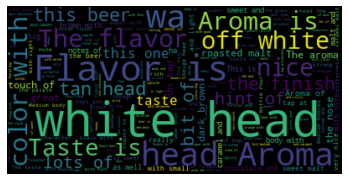

In [36]:
positive_cloud = WordCloud(stopwords = stop_words).generate(positive_string)
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

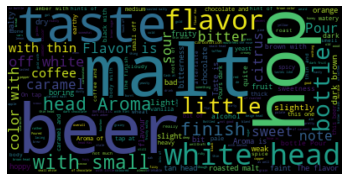

In [37]:
negative_cloud = WordCloud(stopwords = stop_words).generate(negative_string)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

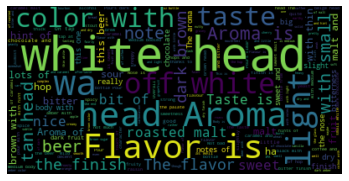

In [38]:
neutral_cloud = WordCloud(stopwords = stop_words).generate(neutral_string)
plt.imshow(neutral_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
reviews_2 = reviews_1.drop(['length', 'lang', 'sentiment'], axis=1)
reviews_2.head()

,name,review,sentiment_1
0,George Killians Irish Red,"I like this beer, it tastes good and has a goo...",2
1,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...,1
2,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...,0
3,Stillwater/Olivers Channel Crossing,Draft @ Capones. Brown pour with tan head. Swe...,2
4,Alpine Beer Company Willy,"Meh, not to impressed with this. Wheaty nose a...",2


In [40]:
reviews_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13780 entries, 0 to 13779
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         13780 non-null  object
 1   review       13780 non-null  object
 2   sentiment_1  13780 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 323.1+ KB


In [41]:
X = reviews_2.drop('sentiment_1', axis=1)
X.head()

,name,review
0,George Killians Irish Red,"I like this beer, it tastes good and has a goo..."
1,Blue Moon Winter Abbey Ale,Thankfully I with beer expert Justin Greene @w...
2,Cigar City Humidor Series Juniper Jai Alai IPA,Entering old rates. 2010 originally as Twigs a...
3,Stillwater/Olivers Channel Crossing,Draft @ Capones. Brown pour with tan head. Swe...
4,Alpine Beer Company Willy,"Meh, not to impressed with this. Wheaty nose a..."


In [42]:
y = reviews_2['sentiment_1']
y.head()

0    2
1    1
2    0
3    2
4    2
Name: sentiment_1, dtype: int64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
X_train.head()

,name,review
6575,Samuel Smiths Oatmeal Stout,"My favorite Oatmeal Stout to date, with a rich..."
4977,Shorts Anniversary Ale Part Deux Original Version,12oz bottle purchased at the brewery. The arom...
4476,Iron Horse Brass Ass Brown Ale,clear brown with a small head. Aroma was sligh...
13295,Central Waters Mud Puppy Porter,As you bring the glass to your lips the roasty...
13442,Chimay Rouge &#40;Red&#41; / Première,"bittersweet, my least favorite of the red whit..."


In [45]:
X_test.head()

,name,review
9152,Iron Hill ESB,Draught at the West Chester location. Sweet f...
43,Rock Bottom Portland Sunny Day IPA,Surprisingly tame nose. well balanced from th...
1933,Rock Bottom Des Moines L’Ange Rouge,"UPDATED: MAY 5, 2010 One of fourty-five beers ..."
13413,Wizard Mother in Law,"Cask conditioned at the Woolpack, Banbury, o..."
999,Stone Double Bastard Ale,Bomber. This one pours amber with an off-white...


In [46]:
X_test = X_test.reset_index().drop('index', axis=1)
X_test

,name,review
0,Iron Hill ESB,Draught at the West Chester location. Sweet f...
1,Rock Bottom Portland Sunny Day IPA,Surprisingly tame nose. well balanced from th...
2,Rock Bottom Des Moines L’Ange Rouge,"UPDATED: MAY 5, 2010 One of fourty-five beers ..."
3,Wizard Mother in Law,"Cask conditioned at the Woolpack, Banbury, o..."
4,Stone Double Bastard Ale,Bomber. This one pours amber with an off-white...
...,...,...
2751,Half Acre Daisy Cutter,On draft at the Hyatt Regency in Chicago. Pou...
2752,Porterhouse Wrasslers XXXX Stout,750ml bottle via trade. What a pain in the as...
2753,Acme California IPA,Super-hoppy nose is lemony and herbal. Dry an...
2754,Telegraph White Ale,My Bottom Line:\t This classic Witbier focuses...


In [47]:
count_vect = CountVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')
count_vect.fit(X_train.review)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [48]:
X_train_transformed = count_vect.transform(X_train.review)
train_df = pd.DataFrame(X_train_transformed.toarray(), columns=count_vect.get_feature_names())
train_df.head()

,00,01,02,03,04,05,06,06 pours,07,08,...,youre,youve,youve got,yum,yummy,zero,zero head,zest,zesty,zing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
print(type(train_df))
print(train_df.shape)
# print(review_text_count.toarray())
##print(count_vect.get_feature_names())
##print(reviews_1.review)

<class 'pandas.core.frame.DataFrame'>
(11024, 10000)


In [50]:
tfidf_trans = TfidfTransformer().fit(train_df)

In [51]:
training_tfidf = tfidf_trans.transform(train_df)
print(type(training_tfidf))
##print(training_tfidf)




<class 'scipy.sparse.csr.csr_matrix'>


In [52]:
tfidf_df = pd.DataFrame(training_tfidf.toarray())
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
test_countvect = count_vect.transform(X_test.review)
test_tfidf = tfidf_trans.transform(test_countvect)
print(type(test_tfidf))
print(pd.DataFrame(test_tfidf.toarray()).shape)

<class 'scipy.sparse.csr.csr_matrix'>
(2756, 10000)


In [54]:
lr = LogisticRegression()
lr.fit(tfidf_df, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred = lr.predict(test_tfidf)

In [56]:
proba = lr.predict_proba(test_tfidf)

In [57]:
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
# print("ROC score = {}\n".format(roc_auc_score(y_test, proba[:,1])))
print("Classification Report:\n{}\n".format(classification_report(y_test, y_pred)))
print("Confusion Matrix:\n{}\n".format(confusion_matrix(y_test, y_pred)))

Accuracy Score: 0.7692307692307693

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       808
           1       0.80      0.03      0.05       141
           2       0.81      0.93      0.87      1807

    accuracy                           0.77      2756
   macro avg       0.75      0.50      0.50      2756
weighted avg       0.76      0.77      0.74      2756


Confusion Matrix:
[[ 432    0  376]
 [ 111    4   26]
 [ 122    1 1684]]



In [58]:
pred_df = pd.DataFrame(X_test['name'], y_pred)
pred_df

,name
2,Rock Bottom Des Moines L’Ange Rouge
2,Rock Bottom Des Moines L’Ange Rouge
2,Rock Bottom Des Moines L’Ange Rouge
2,Rock Bottom Des Moines L’Ange Rouge
2,Rock Bottom Des Moines L’Ange Rouge
...,...
0,Iron Hill ESB
2,Rock Bottom Des Moines L’Ange Rouge
2,Rock Bottom Des Moines L’Ange Rouge
2,Rock Bottom Des Moines L’Ange Rouge


In [59]:
pred_df.to_csv('prediction.csv')

In [60]:
test = pd.read_csv('reviews.csv')
test

,review
0,Fruity aroma on the nose which made me think i...
1,I don't typically like stouts but decided to t...
2,Pils are my favorite beer so I'm sorry to say ...
3,Pours very dark brown with a small short-lasti...
4,Peach juice colour. Bubbly head. Aroma is rasp...
5,Hazy golden colour. Aroma is grassy with some ...
6,"Very clear, pale amber nearing lemon. Only sma..."
7,The beer is a hazy copper-red color with a med...
8,I'm not much of a stout guy buy enjoyed the 20...
9,Interesting pour to this as it had a blueberry...


In [61]:
test_reviews_countvect = count_vect.transform(test.review)
test_reviews_tfidf = tfidf_trans.transform(test_reviews_countvect)
print(type(test_reviews_tfidf))
print(pd.DataFrame(test_reviews_tfidf.toarray()).shape)

<class 'scipy.sparse.csr.csr_matrix'>
(21, 10000)


In [62]:
test_reviews_df = pd.DataFrame()
print(pd.DataFrame(test_reviews_tfidf.toarray()).shape)

(21, 10000)


In [63]:
test_predictions = lr.predict(test_reviews_tfidf)

In [64]:
test_predictions

array([2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [65]:
rf = RandomForestClassifier()
rf.fit(tfidf_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [66]:
rf_prediction = rf.predict(test_tfidf)

In [67]:
print("Accuracy_score: \n {}".format(accuracy_score(y_test, rf_prediction)))
print("Confusion Matrix: \n {}".format(confusion_matrix(y_test, rf_prediction)))

Accuracy_score: 
 0.7155297532656023
Confusion Matrix: 
 [[ 209    1  598]
 [  89    1   51]
 [  45    0 1762]]


In [69]:
rf_predictions = rf.predict(test_reviews_tfidf)

In [70]:
rf_predictions

array([2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [68]:
# Grid Search Cross Validation

In [71]:
param_grid = {'n_estimators':[10, 50, 100],
             'max_features':['auto', 'log2'],
              'max_depth':[4, 8],
              'criterion': ['gini', 'entropy']
             }
rf = RandomForestClassifier()

In [72]:
cv_model = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [73]:
cv_model.fit(tfidf_df, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [74]:
print(cv_model.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 10}


In [75]:
cv_predict = cv_model.predict(test_tfidf)

In [76]:
probs = cv_model.predict_proba(test_tfidf)

In [77]:
print("Accuracy Score: {}\n".format(accuracy_score(y_test, cv_predict)))
# print("ROC score = {}\n".format(roc_auc_score(y_test, probs[:,1])))
print("Classification Report:\n{}\n".format(classification_report(y_test, cv_predict)))
print("Confusion Matrix:\n{}\n".format(confusion_matrix(y_test, cv_predict)))

Accuracy Score: 0.6560232220609579

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.00       808
           1       0.00      0.00      0.00       141
           2       0.66      1.00      0.79      1807

    accuracy                           0.66      2756
   macro avg       0.39      0.33      0.26      2756
weighted avg       0.58      0.66      0.52      2756


Confusion Matrix:
[[   1    0  807]
 [   1    0  140]
 [   0    0 1807]]



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# Trying to balance the class

In [67]:
from sklearn.utils import resample

In [68]:
negative_sentiment = resample(negative, replace=True, n_samples=len(neutral), random_state=123)

In [70]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [72]:
reviews_3 = reviews_2

In [73]:
reviews_3.head()

,name,review,sentiment_1
0,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,2
1,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",2
2,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de...",2
3,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...,0
4,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of...",2


In [81]:
from imblearn.over_sampling import RandomOverSampler


In [82]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [83]:
print(y_resampled.value_counts())

2    9033
1    9033
0    9033
Name: sentiment_1, dtype: int64


In [85]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [100]:
X_test_r = X_test_r.reset_index().drop('index', axis=1)

In [90]:
count_vect_r = CountVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')
count_vect_r.fit(X_train_r.review)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [91]:
X_train_r_transformed = count_vect_r.transform(X_train_r.review)
train_df_r = pd.DataFrame(X_train_r_transformed.toarray(), columns=count_vect_r.get_feature_names())
train_df_r.head()

,01,02,03,04,05,06,06 08,06 10,06 18,06 pours,...,yumm,yummy,zero,zero carbonation,zero head,zest,zest flavor,zesty,zhukovs,zing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
tfidf_trans_r = TfidfTransformer().fit(train_df_r)

In [93]:
training_tfidf_r = tfidf_trans_r.transform(train_df_r)

In [94]:
tfidf_df_r = pd.DataFrame(training_tfidf_r.toarray())
tfidf_df_r.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
test_countvect_r = count_vect_r.transform(X_test_r.review)
test_tfidf_r = tfidf_trans_r.transform(test_countvect_r)
print(type(test_tfidf_r))
print(pd.DataFrame(test_tfidf_r.toarray()).shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5420, 10000)


In [96]:
lr.fit(tfidf_df_r, y_train_r)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
resampled_prediction = lr.predict(test_tfidf_r)

In [98]:
print("Accuracy Score: {}\n".format(accuracy_score(y_test_r, resampled_prediction)))
# print("ROC score = {}\n".format(roc_auc_score(y_test, proba[:,1])))
print("Classification Report:\n{}\n".format(classification_report(y_test_r, resampled_prediction)))
print("Confusion Matrix:\n{}\n".format(confusion_matrix(y_test_r, resampled_prediction)))

Accuracy Score: 0.8915129151291513

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1782
           1       0.94      1.00      0.97      1808
           2       0.89      0.82      0.85      1830

    accuracy                           0.89      5420
   macro avg       0.89      0.89      0.89      5420
weighted avg       0.89      0.89      0.89      5420


Confusion Matrix:
[[1518   75  189]
 [   1 1807    0]
 [ 289   34 1507]]



In [101]:
pred_df_resampled = pd.DataFrame(X_test_r['name'], resampled_prediction)
pred_df_resampled

,name
2,Terrapin Hop Karma Brown IPA
1,Holdens Black Country Mild
2,Terrapin Hop Karma Brown IPA
1,Holdens Black Country Mild
2,Terrapin Hop Karma Brown IPA
...,...
2,Terrapin Hop Karma Brown IPA
0,Big Bear Brown Bear Ale
0,Big Bear Brown Bear Ale
1,Holdens Black Country Mild


In [102]:
pred_df_resampled.to_csv('prediction_resampled.csv')

In [104]:
test_reviews_countvect_r = count_vect_r.transform(test.review)
test_reviews_tfidf_r = tfidf_trans_r.transform(test_reviews_countvect_r)

In [105]:
test_predictions_new = lr.predict(test_reviews_tfidf_r)

In [106]:
test_predictions_new

array([2, 0, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1])

In [107]:
# Random Forest Classifier

In [108]:
rf.fit(tfidf_df_r, y_train_r)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [109]:
rf_resampled_predictions = rf.predict(test_tfidf_r)

In [111]:
print("Accuracy Score: {}\n".format(accuracy_score(y_test_r, rf_resampled_predictions)))
# print("ROC score = {}\n".format(roc_auc_score(y_test, proba[:,1])))
print("Classification Report:\n{}\n".format(classification_report(y_test_r, rf_resampled_predictions)))
print("Confusion Matrix:\n{}\n".format(confusion_matrix(y_test_r, rf_resampled_predictions)))

Accuracy Score: 0.9380073800738007

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1782
           1       0.99      1.00      1.00      1808
           2       0.89      0.93      0.91      1830

    accuracy                           0.94      5420
   macro avg       0.94      0.94      0.94      5420
weighted avg       0.94      0.94      0.94      5420


Confusion Matrix:
[[1571    3  208]
 [   0 1808    0]
 [ 118    7 1705]]



In [112]:
rf_test_predictions_new = rf.predict(test_reviews_tfidf_r)
rf_test_predictions_new

array([2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [113]:
cv_model.fit(tfidf_df_r, y_train_r)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [115]:
cv_resampled_predictions = cv_model.predict(test_tfidf_r)

In [117]:
print("Accuracy Score: {}\n".format(accuracy_score(y_test_r, cv_resampled_predictions)))
# print("ROC score = {}\n".format(roc_auc_score(y_test, proba[:,1])))
print("Classification Report:\n{}\n".format(classification_report(y_test_r, cv_resampled_predictions)))
print("Confusion Matrix:\n{}\n".format(confusion_matrix(y_test_r, cv_resampled_predictions)))

Accuracy Score: 0.73690036900369

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.51      0.61      1782
           1       0.70      0.98      0.82      1808
           2       0.79      0.72      0.75      1830

    accuracy                           0.74      5420
   macro avg       0.74      0.74      0.72      5420
weighted avg       0.74      0.74      0.72      5420


Confusion Matrix:
[[ 908  520  354]
 [  33 1775    0]
 [ 272  247 1311]]



In [118]:
print(cv_model.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}


In [114]:
# Saving the model

In [119]:
import pickle

In [123]:
filename = "finalized_model.h5"
pickle.dump(lr, open(filename, 'wb'))